In [2]:
# !pip install keras
# !pip install pandas
# !pip install tensorflow
# !pip install seaborn
# !pip install -U scikit-learn scipy matplotlib


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns
import numpy as np

2023-05-12 22:24:01.619626: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 22:24:02.017827: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 22:24:02.019097: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 22:24:03.512812: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv('df_kw_subs.csv', sep=';')
df = df.astype({'subs_text': 'string'})
df = df.drop('imdb_id', axis=1)
df=df.iloc[0:100,:]
df


,keylist_fifteen,subs_text
0,"['android', 'spaceopera', 'rebellion', 'planet...","['hear', 'shut', 'main', 'reactor', 'destroy',..."
1,"['basedonnovel', 'love', 'friendship', 'flashb...","['hello', 'name', 'forrest', 'forrest', 'gump'..."
2,"['nudity', 'femalenudity', 'malenudity', 'comi...","['need', 'father', 'role', 'model', 'horny', '..."
3,"['murder', 'friendship', 'smalltown', 'robbery...","['sweat', 'know', 'im', 'excite', 'though', 's..."
4,"['love', 'alien', 'newyorkcity', 'future', 'sh...","['come', 'come', 'please', 'aziz', 'aziz', 'az..."
...,...,...
95,"['independentfilm', 's', 'robbery', 'sheriff',...","['know', 'abbey', 'lincoln', 'know', 'may', 'n..."
96,"['violence', 'drug', 'wedding', 'teacher', 'yo...","['play', 'seven', 'virgins', 'put', 'two', 'ca..."
97,"['murder', 'sex', 'violence', 'prison', 'escap...","['hey', 'sailor', 'wait', 'get', 'something', ..."
98,"['africa', 'boat', 'worldwari', 'faith', 'rive...","['bread', 'heaven', 'bread', 'heaven', 'barren..."


In [4]:
all_sub_words=set()
for sub in df.subs_text:
   for word in eval(sub):
       if word not in all_sub_words:
           all_sub_words.add(word)

all_kw_words=set()
for keylist in df.keylist_fifteen:
   for word in eval(keylist):
       if word not in all_kw_words:
           all_kw_words.add(word)

input_words = sorted(list(all_sub_words))
target_words = sorted(list(all_kw_words))
num_encoder_tokens = len(all_sub_words)
num_decoder_tokens = len(all_kw_words)

input_token_index = dict(
   [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
   [(word, i) for i, word in enumerate(target_words)])

In [5]:
print(f'Длина словаря субтитров: {len(all_sub_words)}, \n\
Максимум слов в субтитрах: {df.subs_text.apply(lambda x: len(eval(x))).max()} \n\
Минимум слов в субтитрах: {df.subs_text.apply(lambda x: len(eval(x))).min()} \n\n\
Длина словаря ключевых слов:{len(all_kw_words)}, \n\
Максимум ключевых слов: {df.keylist_fifteen.apply(lambda x: len(eval(x))).max()}, \n\
Минимум ключевых слов {df.keylist_fifteen.apply(lambda x: len(eval(x))).min()}')

Длина словаря субтитров: 21293, 
Максимум слов в субтитрах: 8845 
Минимум слов в субтитрах: 227 

Длина словаря ключевых слов:891, 
Максимум ключевых слов: 15, 
Минимум ключевых слов 15


0.94


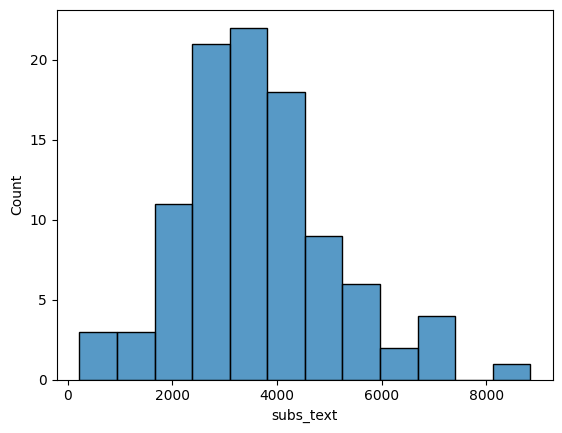

In [6]:
sns.histplot(df.subs_text.apply(lambda x: len(eval(x))))
cnt = 0
for i in df.subs_text:
    if len(eval(i)) <= 6000:
        cnt = cnt + 1
print(cnt / len(df.subs_text))

In [7]:
def add_start_stop(keylist):
    
    keylist = eval(keylist)
    keylist.insert(0, '_START_')
    keylist.insert(0, 'sostok')
    keylist.append('_END_')
    keylist.append('eostok')
    return keylist

df['keylist_fifteen'] = df['keylist_fifteen'].apply(add_start_stop)

In [8]:
df

,keylist_fifteen,subs_text
0,"[sostok, _START_, android, spaceopera, rebelli...","['hear', 'shut', 'main', 'reactor', 'destroy',..."
1,"[sostok, _START_, basedonnovel, love, friendsh...","['hello', 'name', 'forrest', 'forrest', 'gump'..."
2,"[sostok, _START_, nudity, femalenudity, malenu...","['need', 'father', 'role', 'model', 'horny', '..."
3,"[sostok, _START_, murder, friendship, smalltow...","['sweat', 'know', 'im', 'excite', 'though', 's..."
4,"[sostok, _START_, love, alien, newyorkcity, fu...","['come', 'come', 'please', 'aziz', 'aziz', 'az..."
...,...,...
95,"[sostok, _START_, independentfilm, s, robbery,...","['know', 'abbey', 'lincoln', 'know', 'may', 'n..."
96,"[sostok, _START_, violence, drug, wedding, tea...","['play', 'seven', 'virgins', 'put', 'two', 'ca..."
97,"[sostok, _START_, murder, sex, violence, priso...","['hey', 'sailor', 'wait', 'get', 'something', ..."
98,"[sostok, _START_, africa, boat, worldwari, fai...","['bread', 'heaven', 'bread', 'heaven', 'barren..."


In [9]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 6000
max_summary_len = 15

,keylist_fifteen,subs_text
0,"[sostok, _START_, android, spaceopera, rebelli...","['hear', 'shut', 'main', 'reactor', 'destroy',..."
1,"[sostok, _START_, basedonnovel, love, friendsh...","['hello', 'name', 'forrest', 'forrest', 'gump'..."
2,"[sostok, _START_, nudity, femalenudity, malenu...","['need', 'father', 'role', 'model', 'horny', '..."
3,"[sostok, _START_, murder, friendship, smalltow...","['sweat', 'know', 'im', 'excite', 'though', 's..."
4,"[sostok, _START_, love, alien, newyorkcity, fu...","['come', 'come', 'please', 'aziz', 'aziz', 'az..."
...,...,...
94,"[sostok, _START_, gay, robbery, fathersonrelat...","['five', 'six', 'seven', 'eight', 'nine', 'alw..."
95,"[sostok, _START_, independentfilm, s, robbery,...","['know', 'abbey', 'lincoln', 'know', 'may', 'n..."
96,"[sostok, _START_, violence, drug, wedding, tea...","['play', 'seven', 'virgins', 'put', 'two', 'ca..."
97,"[sostok, _START_, murder, sex, violence, priso...","['hey', 'sailor', 'wait', 'get', 'something', ..."


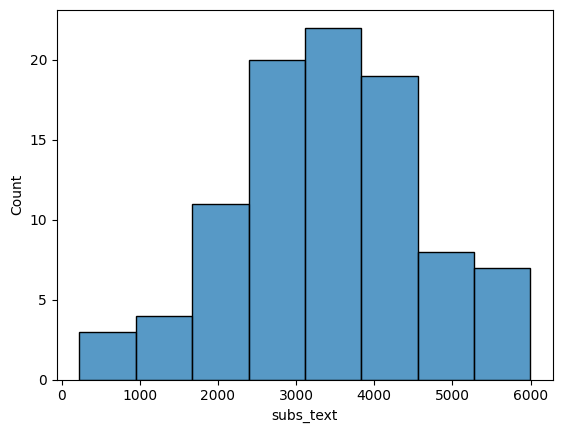

In [10]:
df=df[df['subs_text'].apply(lambda x: len(eval(x))) <= max_text_len]
sns.histplot(df.subs_text.apply(lambda x: len(eval(x))))
df

In [11]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(df["subs_text"]),
    np.array(df["keylist_fifteen"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [12]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(x_tr)

In [13]:
thresh = 2

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  46.05795866183678


In [14]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 10127


In [15]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(y_tr)

thresh = 2

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 70.28360049321824
Size of vocabulary in Y = 242


In [16]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


2023-05-12 22:24:26.063376: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6000, 200)    2025400     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 6000, 300),  601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [17]:
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [26]:
# history = model.fit(
#     [x_tr, y_tr[:, :-1]],
#     y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
#     epochs=50,
#     callbacks=[es],
#     batch_size=128,
#     validation_data=([x_val, y_val[:, :-1]],
#                      y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
#                      , 1:]),
#     )

Epoch 1/50


2023-05-12 22:17:10.463754: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2023-05-12 22:17:10.601833: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


In [22]:
import tensorflow as tf
model = tf.keras.models.load_model('colab_200_films_model')

In [23]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index


In [24]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [25]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [26]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [28]:
for i in range(0, 19):
    # print('Review:', seq2text(x_tr[i]))
    print('Original summary:', seq2summary(y_tr[i]))
    print('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print('\n')

Review: 'counselor' 'get' 'come' 'good' 'forgive' 'early' 'intrusion' 'great' 'admirer' 'honor' 'meet' 'may' 'use' 'typewriter' 'sir' 'arm' 'please' 'relax' 'age' 'cook' 'another' 'film' 'without' 'hope' 'first' 'time' 'take' 'cure' 'yes' 'take' 'deep' 'breath' 'come' 'im' 'sorry' 'come' 'back' 'later' 'come' 'breathe' 'deeper' 'good' 'morning' 'may' 'smoke' 'cough' 'breathe' 'already' 'read' 'yes' 'breathe' 'think' 'well' 'make' 'note' 'talk' 'later' 'system' 'bite' 'wear' 'may' 'get' 'dress' 'nice' 'look' 'girl' 'american' 'right' 'get' 'fine' 'merchandise' 'treatment' 'good' 'see' 'nurse' 'ml' 'holy' 'water' 'dose' 'take' 'minute' 'intervals' 'empty' 'stomach' 'mud' 'bath' 'every' 'day' 'time' 'mud' 'bath' 'ten' 'minutes' 'mineral' 'water' 'prescribe' 'wait' 'spring' 'yes' 'thank' 'sir' 'sir' 'glass' 'want' 'talk' 'film' 'yes' 'course' 'fine' 'tell' 'would' 'like' 'producer' 'see' 'report' 'frankly' 'would' 'want' 'one' 'cause' 'trouble' 'worry' 'im' 'one' 'call' 'first' 'read' 'evi

KeyboardInterrupt: 